# **脑部MRI分割系统项目概要文档**

---

##### **1. 项目概述**

**目标**：开发一个端到端的脑部MRI肿瘤分割系统，实现从数据预处理到模型训练评估的全流程

**核心价值**：

- 为医学影像分析提供可复现的深度学习基准方案
- 验证U-Net在脑肿瘤分割任务中的有效性
- 输出可直接用于临床研究的模型和可视化结果

##### **2. 功能需求**

**2.1 数据预处理模块**

| 功能       | 技术指标                                             |
|------------|------------------------------------------------------|
| 数据加载   | 支持`kaggle_3m`数据集格式，自动匹配图像-掩膜对       |
| 数据过滤   | 剔除空白掩膜样本（肿瘤面积为0的病例）                |
| 数据增强   | 标准化Resize(256×256) + ToTensor转换                 |
| 数据集划分 | 按8:2比例分割训练集/验证集，固定随机种子保证可复现性 |

**2.2 深度学习模型**

| 组件     | 参数规格                       |
|----------|--------------------------------|
| 网络架构 | 经典U-Net：4层编码器-4层解码器 |
| 卷积模块 | DoubleConv(Conv3×3+BN+ReLU)×2  |
| 下采样   | MaxPool2d(k=2) 实现4倍降采样   |
| 上采样   | ConvTranspose2d(k=2, s=2)      |
| 输出层   | Conv1×1 + Sigmoid激活          |

**2.3 训练评估流程**

    训练流程：
    1. 输入：3通道256×256 MRI图像 
    2. 优化器：Adam(lr=0.001)
    3. 损失函数：BCEWithLogitsLoss 
    4. 评估指标：Dice系数（医学分割金标准）
     
    验证流程：
    1. 每epoch验证集测试 
    2. 自动保存最佳模型（best_model.pth ）

**2.4 可视化系统**

- **训练监控**：实时输出Train/Val Loss和Dice系数
- **结果对比**：三联图显示（原始图像、金标准掩膜、预测结果）
- **输出格式**：支持Matplotlib交互式显示和PNG导出

##### **3. 项目目标**
**3.1 性能指标**

| 场景          | 要求                       |
|---------------|----------------------------|
| 单GPU训练速度 | ≥8 samples/sec（RTX 3090） |
| 推理延迟      | ≤50ms/图像（256×256）      |
| 模型体积      | ≤200MB（.pth格式）         |

**3.2 数据要求**

- **输入数据**：T1加权脑部MRI（推荐3T扫描仪数据）
- **标注标准**：二值掩膜（0=正常组织，1=肿瘤区域）
- **最小数据集**：≥100个有效病例（含肿瘤样本）

##### **4. 技术架构**

**4.1 系统流程图**

    graph TD 
        A[原始DICOM数据] --> B[转换为PNG格式]
        B --> C[数据预处理]
        C --> D[U-Net模型训练]
        D --> E[模型评估]
        E --> F[可视化输出]

**4.2 开发环境**

软件环境：
- Python ≥3.8 
- PyTorch ≥2.0 
- OpenCV-Python 
- Pillow ≥9.0 
     
硬件环境：
- 最低配置：NVIDIA GPU(≥8GB显存)
- 备用方案：CPU模式（需≥32GB内存）

**4.3 关键算法**

1.  **数据平衡策略**：自动过滤无肿瘤样本
2.  **医学图像增强**：保留HU值范围的归一化方法
3.  **损失函数优化**：BCE+Dice联合损失

##### 5. 代码实现

In [1]:
# 颅脑影像图像分割项目
"""
脑部MRI分割完整流程(U-Net实现)
包含数据加载、模型定义、训练和评估全流程
支持GPU加速
"""
# 显示每个cell执行时间
%load_ext autotime
# matplotlib交互绘图
%matplotlib ipympl

from matplotlib import get_backend
get_backend()

'ipympl'

time: 725 ms (started: 2025-07-10 09:23:40 +08:00)


Using device: cuda

Epoch 1/1


Validating: 	100.0%|██████████| 35/35 [00:07<00:00,  4.71it/s]


Train Loss: 0.7183 | Train Dice: 0.0749
Val   Loss: 0.6909 | Val   Dice: 0.1059
Saved best model!
----------------------------------------------------------------------------------------------------

Best Dice: 0.1059
图像形状: (8, 256, 256, 3)
掩码形状: (8, 256, 256)
预测形状: (8, 256, 256)


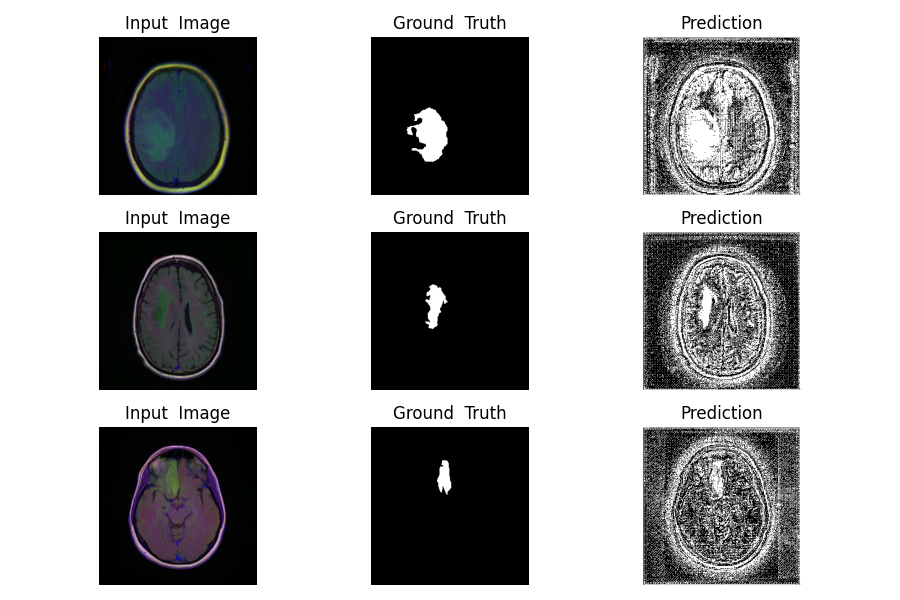

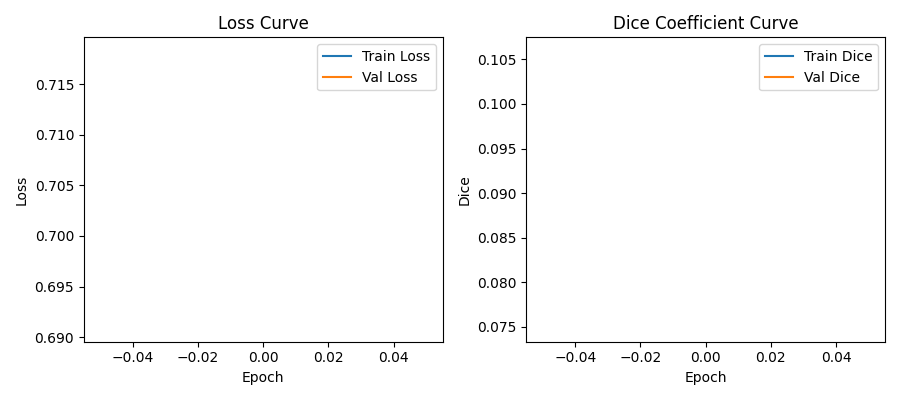

time: 1min 29s (started: 2025-07-10 09:23:41 +08:00)


In [2]:
from module_src.main import get_loader, run
from module_src.data_prep import BrainMRIDataset
from module_src.model_def import UNet

from torchvision import transforms  # 图像预处理
from torch.nn import BCEWithLogitsLoss
import torch

# ====================== 5. 主程序 ======================
def main():
    """主训练流程"""
    # ===== 参数设置 =====
    base_dir = '/data/coding'
    data_dir = base_dir + '/kaggle_3m'  # 数据目录路径
    batch_size, num_epochs, lr = 8, 1, 0.000001
    
    # 自动检测设备 (优先使用GPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}\n")
    # ===== 数据预处理 ===== 
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # 调整尺寸 
        transforms.ToTensor(),          # 转为Tensor并归一化到[0,1]
    ])
    # 创建数据集 
    train_dataset = BrainMRIDataset(data_dir, transform=transform, train=True)
    val_dataset = BrainMRIDataset(data_dir, transform=transform, train=False)
    # 创建数据加载器
    train_loader = get_loader(train_dataset, batch_size, True, 4)
    val_loader = get_loader(val_dataset, batch_size, False, 4)

    # for img_path in val_dataset.image_paths[0:3]:
    #     print(img_path)

    # 初始化模型 
    model = UNet(n_channels=3, n_classes=1).to(device)
    # 损失函数和优化器
    criterion = BCEWithLogitsLoss()  # 二分类交叉熵损失 (带sigmoid)
    optimizer = torch.optim.Adam(model.parameters(),  lr=lr)
    
    # 训练过程指标
    rates = {'train_loss': [], 'val_loss': [], 'train_dice':[], 'val_dice':[]}
    best_dice = 0.0
    # 开始执行
    run(
        rates, best_dice,
        model=model, device=device, criterion=criterion,
        train_loader=train_loader, val_loader=val_loader,
        optimizer=optimizer, epoch=num_epochs
    )

if __name__ == '__main__':
    """程序入口"""
    main()

In [3]:
# from os import system, getpid
# # 避免IPython后台异常显存占用
# system('kill %d' % getpid())

time: 1.32 ms (started: 2025-07-10 09:25:12 +08:00)
